In [1]:
!pip install pmdarima mxnet -q
!pip install gluonts -q
!pip install tqdm -q

     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 49.1 MB 152 kB/s 
     |████████████████████████████████| 9.8 MB 11.3 MB/s 
     |████████████████████████████████| 2.5 MB 5.4 MB/s 


# Util functions for testing

In [2]:
'''
Util functions for testing metircs
'''
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

# Import processed data from 01 Notebook

In [3]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
# from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecasting/processed_data.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
print(df.shape)
df.head()

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


2.8.2
(244, 81)


,"Alberta - All grains, total",Alberta - Barley,Alberta - Canola (rapeseed),Alberta - Durum wheat,Alberta - Flaxseed,Alberta - Oats,Alberta - Rye,"Alberta - Wheat, excluding durum","Alberta - Wheat, total","British Columbia - All grains, total",...,"Saskatchewan - Wheat, total","Western Canada - All grains, total",Western Canada - Barley,Western Canada - Canola (rapeseed),Western Canada - Durum wheat,Western Canada - Flaxseed,Western Canada - Oats,Western Canada - Rye,"Western Canada - Wheat, excluding durum","Western Canada - Wheat, total"
date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,681600.0,85436.0,146513.0,44449.0,1359.0,19848.0,2657.0,381339.0,425788.0,17191.0,...,716236.0,2179389.0,291993.0,349346.0,298080.0,31220.0,115986.0,6661.0,1086103.0,1384182.0
2002-02-01,656012.0,81684.0,102276.0,46981.0,1285.0,21125.0,2455.0,400206.0,447187.0,22949.0,...,832954.0,2261060.0,267129.0,317269.0,273211.0,34496.0,105906.0,5065.0,1257985.0,1531195.0
2002-03-01,709764.0,82302.0,162041.0,46274.0,1272.0,19095.0,2224.0,396556.0,442830.0,23692.0,...,495936.0,1998799.0,268092.0,369485.0,181507.0,36847.0,93013.0,5096.0,1044761.0,1226267.0
2002-04-01,514491.0,89661.0,61934.0,44058.0,1648.0,13411.0,1921.0,301856.0,345914.0,8703.0,...,630229.0,1911038.0,276394.0,240063.0,293549.0,30497.0,59216.0,4310.0,1007009.0,1300558.0
2002-05-01,572599.0,79232.0,135586.0,38787.0,1750.0,16214.0,2435.0,298594.0,337381.0,8183.0,...,486712.0,1807572.0,234692.0,329466.0,277873.0,60713.0,59476.0,4902.0,840451.0,1118324.0


# Methods for time series forecasting

There're many ways to forecast and each has its pros and cons. It's important to consider whether your data have additional regressors (aka features) to our TS or just the series it self. Let's try both cases, time series with and without extra regressors.

## Prepare data

In [4]:
resultsDict = {}
predictionsDict = {}

# We split our dataset to be able to evaluate our models
split_rate = 0.666
df_training = df.iloc[: int(split_rate * df.shape[0])]
df_test = df.iloc[int(split_rate * df.shape[0]) :]
print(df_training.shape)
print(df_test.shape)

(162, 81)
(82, 81)


We have 162 months of training data and 82 months of testing data

It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [5]:
# 47  Ontario - Wheat, total                      162 non-null    float64
df_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 2002-01-01 to 2015-06-01
Data columns (total 81 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Alberta - All grains, total                 162 non-null    float64
 1   Alberta - Barley                            162 non-null    float64
 2   Alberta - Canola (rapeseed)                 162 non-null    float64
 3   Alberta - Durum wheat                       162 non-null    float64
 4   Alberta - Flaxseed                          162 non-null    float64
 5   Alberta - Oats                              162 non-null    float64
 6   Alberta - Rye                               162 non-null    float64
 7   Alberta - Wheat, excluding durum            162 non-null    float64
 8   Alberta - Wheat, total                      162 non-null    float64
 9   British Columbia - All grains, total        162 non-null    float64


In [6]:
X = df_training['Ontario - Wheat, total']
y = df_test['Ontario - Wheat, total']

In [7]:
# Also add the naive mean average value
mean = X.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(y, mean)
predictionsDict['Naive mean'] = mean


## Univariate TS Forecasting
Univariate forecasting models do not need other regressors (more variables).

### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [8]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(y))):
    temp_train = df[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train['Ontario - Wheat, total'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test['Ontario - Wheat, total'], yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 82/82 [00:02<00:00, 28.45it/s]


## Holt Winter’s Exponential Smoothing (HWES)


In [9]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(y))):
    temp_train = df[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train['Ontario - Wheat, total'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test['Ontario - Wheat, total'], yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 82/82 [00:03<00:00, 27.04it/s]


## Autoregression (AR)

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [10]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Ontario - Wheat, total']))):
    temp_train = df[:len(df_training)+t]
    model = AutoReg(temp_train['Ontario - Wheat, total'], lags=12)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test['Ontario - Wheat, total'], yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 82/82 [00:01<00:00, 57.29it/s]


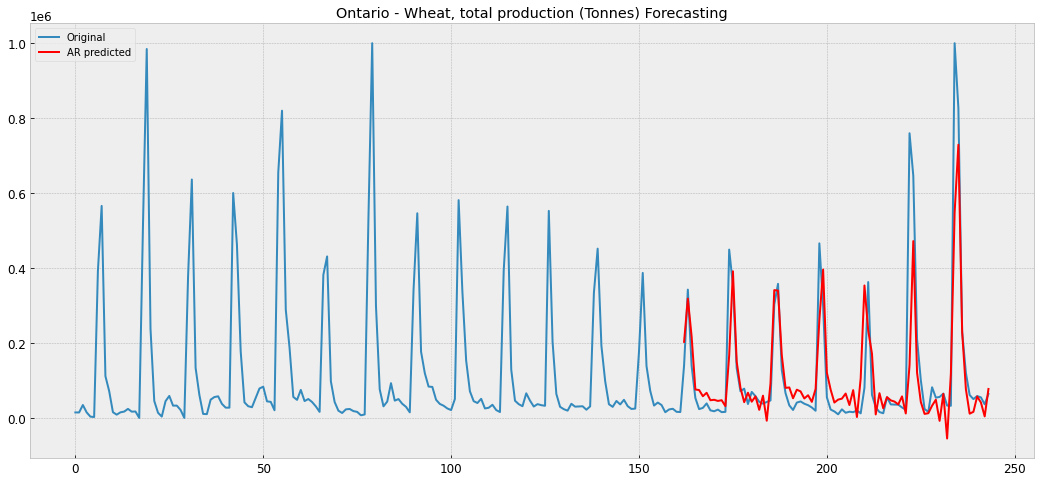

In [11]:
x = np.arange(df.shape[0])
plt.plot(df['Ontario - Wheat, total'].values, label='Original')
plt.plot(x[162:], yhat.values, color='red', label='AR predicted')
plt.title("Ontario - Wheat, total production (Tonnes) Forecasting")
plt.legend()

## Moving Average (MA)
The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [13]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Ontario - Wheat, total']))):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train['Ontario - Wheat, total'], order=(0, 0, 12)) # (p, d, q)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test['Ontario - Wheat, total'], yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 82/82 [01:23<00:00,  1.02s/it]


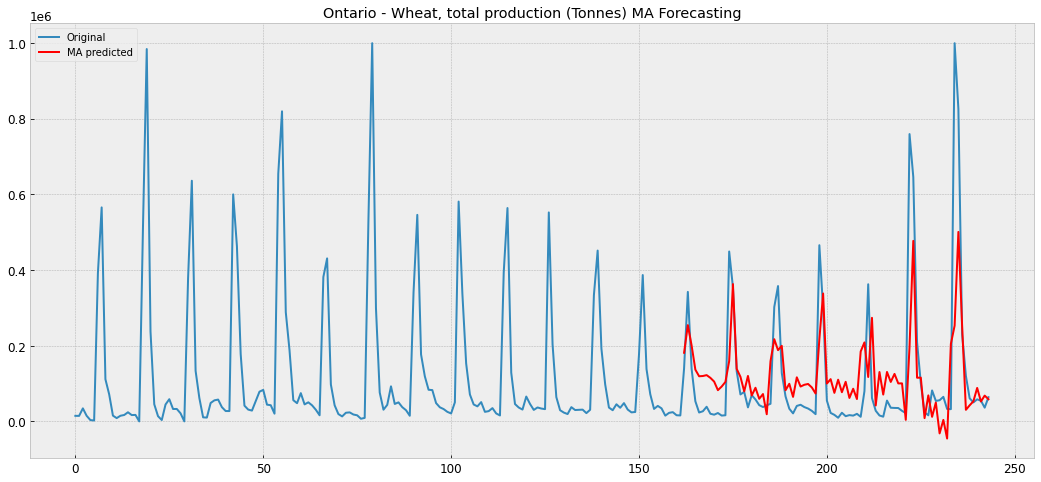

In [14]:
x = np.arange(df.shape[0])
plt.plot(df['Ontario - Wheat, total'].values, label='Original')
plt.plot(x[162:], yhat.values, color='red', label='MA predicted')
plt.title("Ontario - Wheat, total production (Tonnes) MA Forecasting")
plt.legend()


## Autoregressive integrated moving average (ARIMA)
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

1. Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

1. Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

1. Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

### Tuning ARIMA parameters

Non stationarity series will require level of differencing (d) >0 in ARIMA Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

## Auto ARIMA

In [15]:
# building the model
autoModel = pm.auto_arima(df_training['Ontario - Wheat, total'], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=True)
autoModel.fit(df_training['Ontario - Wheat, total'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4345.243, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4404.609, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4365.057, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4344.669, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4458.604, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4345.558, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4345.624, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4345.297, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4371.577, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.624 seconds


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

In [16]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test['Ontario - Wheat, total']))):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train['Ontario - Wheat, total'], order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test['Ontario - Wheat, total'], yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 82/82 [00:06<00:00, 12.57it/s]


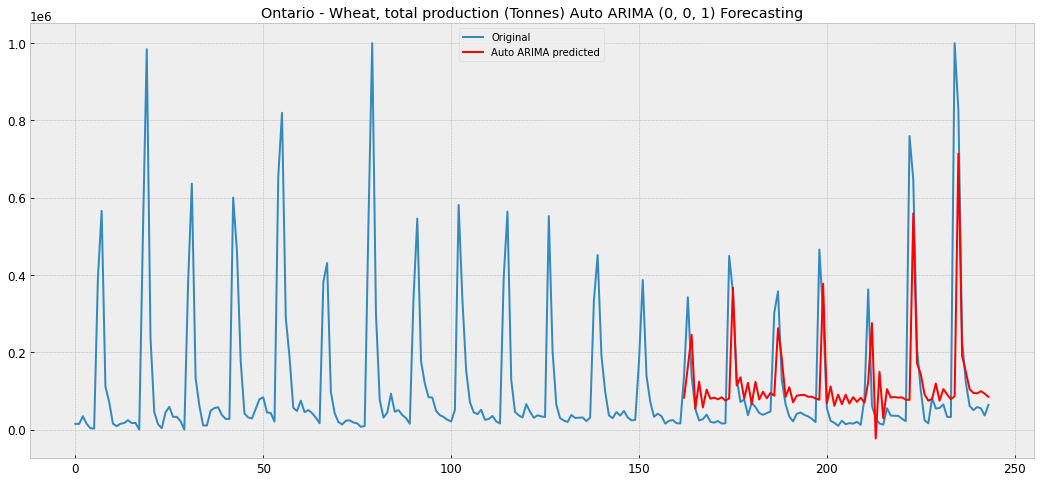

In [17]:
x = np.arange(df.shape[0])
plt.plot(df['Ontario - Wheat, total'].values, label='Original')
plt.plot(x[162:], yhat.values, color='red', label='Auto ARIMA predicted')
plt.title("Ontario - Wheat, total production (Tonnes) Auto ARIMA (0, 0, 1) Forecasting")
plt.legend()

## Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**Trend Elements:**

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

p: Trend autoregression order.  
d: Trend difference order.  
q: Trend moving average order.  

**Seasonal Elements:**

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.  
D: Seasonal difference order.  
Q: Seasonal moving average order.  
m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.  

**SARIMA notation:** SARIMA(p,d,q)(P,D,Q,m)

100%|██████████| 82/82 [00:03<00:00, 24.25it/s]


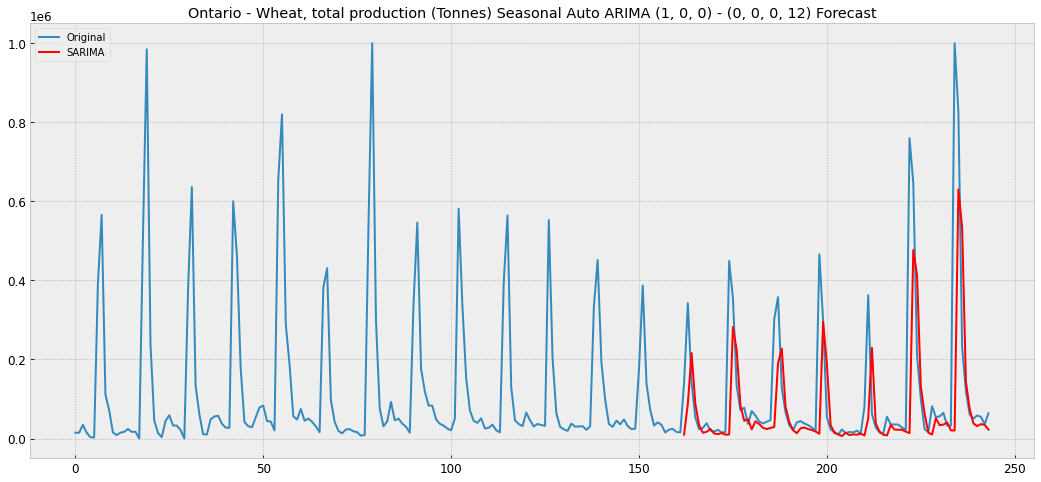

In [18]:
order = (1, 0, 0)
seasonal_order = (0, 0, 0, 12)
yhat = list()
for t in tqdm(range(len(df_test['Ontario - Wheat, total']))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train['Ontario - Wheat, total'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test['Ontario - Wheat, total'], yhat)
predictionsDict['SARIMAX'] = yhat.values

x = np.arange(df.shape[0])
plt.plot(df['Ontario - Wheat, total'].values, label='Original')
plt.plot(x[162:], yhat.values, color='red', label='SARIMA')
plt.title(f"Ontario - Wheat, total production (Tonnes) Seasonal Auto ARIMA {order} - {seasonal_order} Forecast")
plt.legend()

## Auto - SARIMA

In [19]:
# building the model
autoModel = pm.auto_arima(df_training['Ontario - Wheat, total'], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training['Ontario - Wheat, total'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=4404.609, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=4366.813, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=4346.348, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=4458.604, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=4344.669, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[6] intercept   : AIC=4346.597, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[6] intercept   : AIC=4344.639, Time=0.10 sec
 ARIMA(0,0,1)(2,0,1)[6] intercept   : AIC=4266.932, Time=0.25 sec
 ARIMA(0,0,1)(2,0,0)[6] intercept   : AIC=4273.685, Time=0.15 sec
 ARIMA(0,0,1)(2,0,2)[6] intercept   : AIC=4265.362, Time=0.49 sec
 ARIMA(0,0,1)(1,0,2)[6] intercept   : AIC=4304.593, Time=0.23 sec
 ARIMA(0,0,0)(2,0,2)[6] intercept   : AIC=4313.455, Time=0.35 sec
 ARIMA(1,0,1)(2,0,2)[6] intercept   : AIC=4263.562, Time=0.68 sec
 ARIMA(1,0,1)(1,0,2)[6] intercept   : 

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 0, 2, 6),
      suppress_warnings=True)

In [ ]:
order = autoModel.order
seasonal_order = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test['Ontario - Wheat, total']))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train['Ontario - Wheat, total'], order=order, seasonal_order=(2,0,2,12))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]


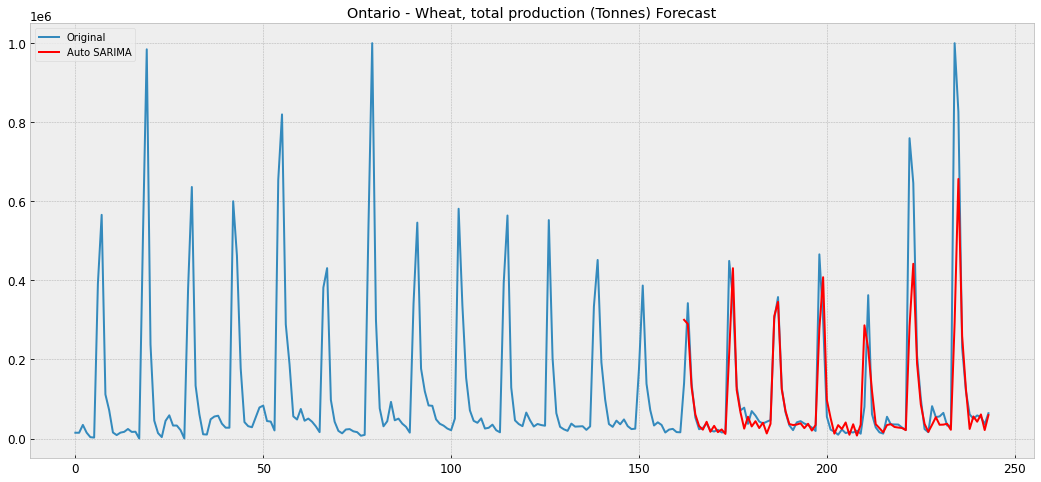

In [26]:
# yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonal_order)] = evaluate(
    df_test['Western Canada - Wheat, total'], yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(order, seasonal_order)] = yhat.values

x = np.arange(df.shape[0])
plt.plot(df['Ontario - Wheat, total'].values, label='Original')
plt.plot(x[162:], yhat.values, color='red', label='Auto SARIMA')
plt.title("Ontario - Wheat, total production (Tonnes) Forecast")
plt.legend()

## Prophet
Prophet is a model released by facebook (now Meta). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.

In [30]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'Ontario - Wheat, total': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'Ontario - Wheat, total': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [34]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='Canada')

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test['Ontario - Wheat, total'], yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values


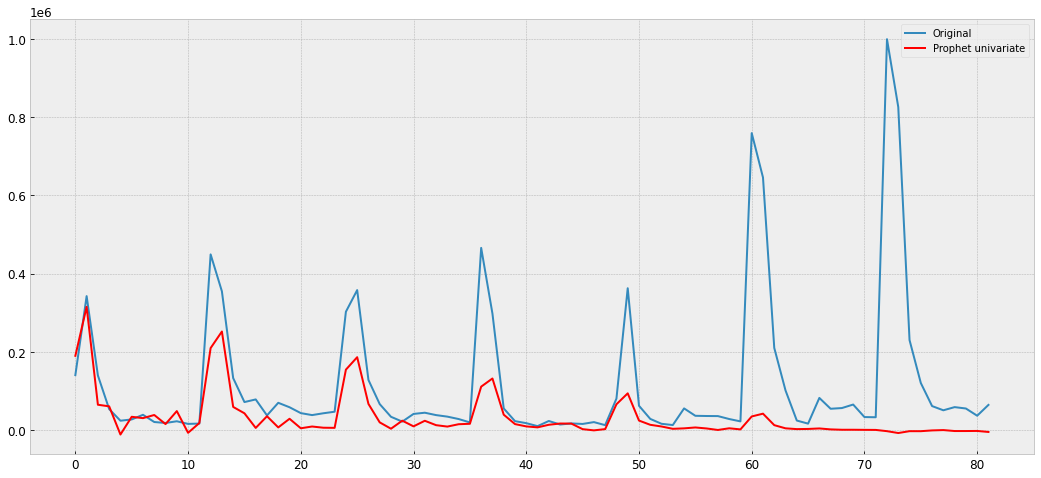

In [37]:
plt.plot(df_test['Ontario - Wheat, total'].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()